# Introduction to Interprenet

Interprenet builds constrained neural networks. We currently support monotonic and lipschitz constraints. This tutorial will show how to apply interpretable constraints to a model trained on the diabetes dataset.

In [1]:
import pandas
from sklearn.datasets import load_diabetes

bunch = load_diabetes()
X = pandas.DataFrame(bunch['data'], columns=bunch['feature_names'])
y = bunch['target']
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


We can get a quick ballpark of which variables exhibit monotonic relations with the target using correlation.

In [2]:
import numpy

correlations = dict(map(reversed,
         sorted(((numpy.corrcoef(X[column], y)[0, 1], column) for column in X.columns),
                key=lambda x: -abs(x[0]))))
correlations

{'bmi': 0.5864501344746885,
 's5': 0.5658825924427437,
 'bp': 0.4414817585625709,
 's4': 0.4304528847447728,
 's3': -0.3947892506709185,
 's6': 0.38248348424858103,
 's1': 0.21202248101455073,
 'age': 0.1878887507189199,
 's2': 0.17405358696874265,
 'sex': 0.04306199845160533}

See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html for details on the meaning of each column.

Let's say the following variables do and should exhibit monotonic relations with the target:

- bmi        median income in block group
- s3      average number of rooms per household

In [3]:
import jax

from mvtk import interprenet

constraints = {
    'bmi': frozenset([interprenet.monotonic_constraint]),
    's5': frozenset(),
    'bp': frozenset(),
    's4': frozenset(),
    's3': frozenset([interprenet.monotonic_constraint]),
    's6': frozenset(),
    's1': frozenset(),
    'age': frozenset(),
    's2': frozenset(),
    'sex': frozenset(),
}

def get_scale(column):
    scale = 1
    if interprenet.monotonic_constraint in constraints[column]:
        # monotonic decreasing features need their sign flipped
        # before entering the neural network
        scale *= numpy.sign(correlations[column])
    if interprenet.lipschitz_constraint in constraints[column]:
        # one can also control the maximum rate of change with lipschitz constraint
        # For example, we could constrain features to increase the target at a rate
        # no faster than twice its correlation with the target
        scale *= 2 * abs(correlations[column])
    return scale

rescale = lambda x: x * numpy.asarray(list(map(get_scale, X.columns)))
init_params, model = interprenet.constrained_model(
    tuple(constraints[column] for column in X.columns),
    preprocess=rescale,
    postprocess=jax.nn.relu) # monotonicity and lipschitz preserving way of eliminating negative prices

In [4]:
import jax
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(jax.numpy.asarray(X.values),
                                                    jax.numpy.asarray(y.astype('float')),
                                                    test_size=0.2,
                                                    random_state=0)

In [5]:
def mean_absolute_percentage_error(y, y_pred):
    return (abs(y - y_pred) / y).mean()

trained_params = interprenet.train((X_train, y_train),
                                   (X_test, y_test),
                                   (init_params, model),
                                   metric=lambda y, y_pred: -mean_absolute_percentage_error(y, y_pred),
                                   loss_fn=mean_absolute_percentage_error,
                                   num_epochs=64)

In [6]:
trained_model = lambda X: model(trained_params, X)
mean_absolute_percentage_error(y_test, trained_model(X_test))

Array(0.41869116, dtype=float32)

No matter what the values of the other features are (blue lines) increasing `bmi` always increases the prediction.

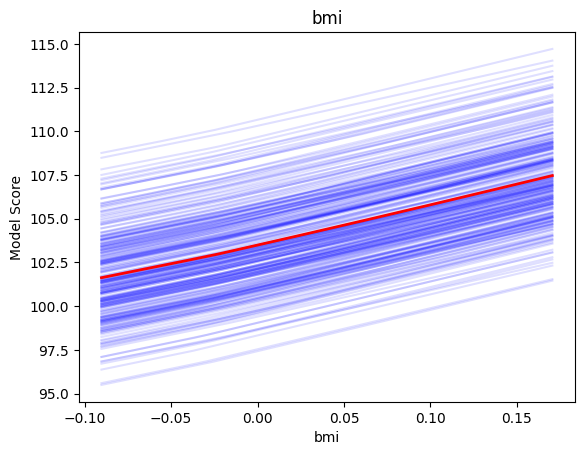

In [7]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 'bmi')
plt.show()

No matter what the values of the other features are (blue lines) increasing `s3` always decreases the prediction.

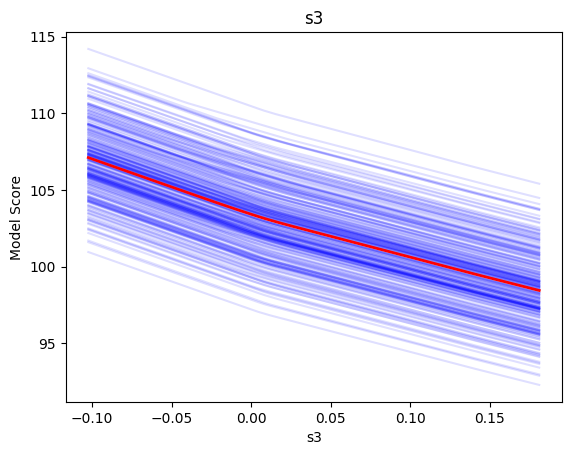

In [8]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 's3')
plt.show()

`s1` can increase or decrease the output.

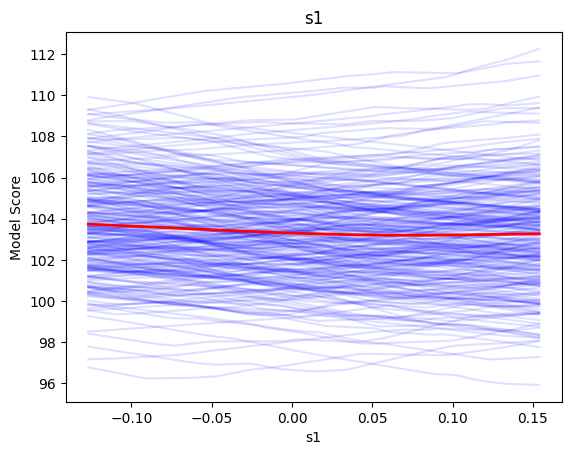

In [9]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 's1')
plt.show()